In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from tueplots import figsizes, fontsizes, fonts, bundles, axes

from histaug.analysis.bootstrap import compare_bootstraps
from histaug.analysis.collect_results import load_results
from histaug.utils.display import RENAME_MODELS, RENAME_FEATURE_EXTRACTORS, FEATURE_EXTRACTOR_GROUPS
from histaug.utils import rc_context, savefig

In [2]:
results = load_results()
df = compare_bootstraps(results, "magnification", "high", "low")
df

2024-02-01 23:54:40.545 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading results from cache
2024-02-01 23:54:40.674 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_magnification_high_vs_low_25_2110f8f095360e1c4c5466e8ecafe2c0 from cache


train_dataset  \
augmentations     feature_extractor model        target                       
Macenko_patchwise bt                AttentionMIL CDH1        tcga_brca_CDH1   
                                                 CDH1        tcga_brca_CDH1   
                                                 CDH1        tcga_brca_CDH1   
                                                 CDH1        tcga_brca_CDH1   
                                                 CDH1        tcga_brca_CDH1   
...                                                                     ...   
none              vits              AttentionMIL subtype  tcga_brca_subtype   
                                                 subtype  tcga_brca_subtype   
                                                 subtype  tcga_brca_subtype   
                                                 subtype  tcga_brca_subtype   
                                                 subtype  tcga_brca_subtype   

                                                                test_dataset  \
augmentations     feature_extractor model        target                        
Macenko_patchwise bt                AttentionMIL CDH1        cptac_brca_CDH1   
                                                 CDH1        cptac_brca_CDH1   
                                                 CDH1        cptac_brca_CDH1   
                                                 CDH1        cptac_brca_CDH1   
                                                 CDH1        cptac_brca_CDH1   
...                                                                      ...   
none              vits              AttentionMIL subtype  cptac_brca_subtype   
                                                 subtype  cptac_brca_subtype   
                                                 subtype  cptac_brca_subtype   
                                                 subtype  cptac_brca_subtype   
                                                 subtype  cptac_brca_subtype   

                                                          auroc_diff  
augmentations     feature_extractor model        target               
Macenko_patchwise bt                AttentionMIL CDH1       0.153726  
                                                 CDH1       0.080000  
                                                 CDH1       0.134771  
                                                 CDH1       0.138988  
                                                 CDH1       0.121645  
...                                                              ...  
none              vits              AttentionMIL subtype   -0.031617  
                                                 subtype   -0.039148  
                                                 subtype   -0.027897  
                                                 subtype   -0.035023  
                                                 subtype   -0.034340  

[12000 rows x 3 columns]

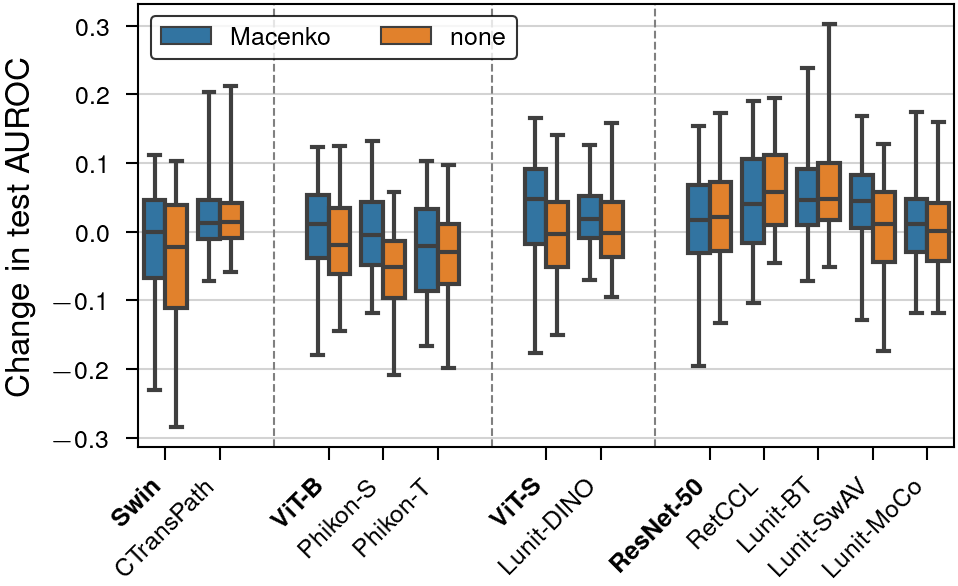

In [6]:
def format_feature_extractor(new_name: str):
    if new_name in FEATURE_EXTRACTOR_GROUPS:
        return f"\\textbf{{{new_name}}}"
    return new_name


df["Feature extractor"] = (
    df.index.get_level_values("feature_extractor").map(RENAME_FEATURE_EXTRACTORS).map(format_feature_extractor)
)
df["Augmentation"] = df.index.get_level_values("augmentations").map(
    lambda x: {
        "none": "none",
        "Macenko_patchwise": "Macenko",
    }.get(x, x)
)

model = "AttentionMIL"

with rc_context("half"):
    plt.figure()
    # Boxplot with 95% confidence interval
    sns.boxplot(
        data=df.query("model == @model"),
        x="Feature extractor",
        y="auroc_diff",
        hue="Augmentation",
        order=[
            x
            for y in [
                [
                    *([" " * i] if i != 0 else []),
                    *[format_feature_extractor(RENAME_FEATURE_EXTRACTORS[extractor]) for extractor in extractors],
                ]
                for i, extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
            ]
            for x in y
        ],
        # ensure 95% confidence interval is shown
        showfliers=False,
        whis=[2.5, 97.5],
        # show all data points
        # showmeans=True,
    )

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha="right")
    # plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(1.0, 1.05), borderaxespad=0.0)
    plt.legend(loc="upper left", ncol=2)
    plt.ylabel("Change in test AUROC")
    plt.xlabel("")

    i = 0
    xticks = []
    for group in FEATURE_EXTRACTOR_GROUPS.values():
        xticks.extend(range(i, i + len(group)))
        if i != 0:
            plt.axvline(x=i - 1, linestyle="--", color="grey", linewidth=0.5)
        i += len(group) + 1

    plt.xticks(xticks, rotation=45, ha="right")

    # light grey grid
    plt.grid(axis="y", color="lightgrey")
    plt.xlabel("")
    # plt.title("Performance with vs.\\ without stain normalisation (AttMIL)")
    # savefig(f"bootstrap_augmentations_{MAGNIFICATION}_{model}_{'_'.join(augmentation_groups_to_compare)}")
    plt.show()

In [8]:
from functools import partial

d = (
    df.reset_index()
    .groupby(["augmentations", "model", "feature_extractor"])["auroc_diff"]
    .agg(["mean", partial(pd.Series.quantile, q=0.025), partial(pd.Series.quantile, q=0.975)])
)
d.columns = ["mean", "ci_lo", "ci_hi"]
d = (
    "$"
    + d["mean"].map(lambda x: f"{x:+.3f}")
    + "\\ ["
    + d["ci_lo"].map(lambda x: f"{x:.3f}")
    + ", "
    + d["ci_hi"].map(lambda x: f"{x:.3f}")
    + "]$"
)
d = d.unstack("augmentations")
d = d.reset_index()
d = d.sort_values(
    by=["model", "feature_extractor"],
    key=lambda series: series.map(
        lambda x: list(
            RENAME_FEATURE_EXTRACTORS.keys() if series.name == "feature_extractor" else RENAME_MODELS.keys()
        ).index(x)
    ),
)
d["model"] = d["model"].map(RENAME_MODELS)
d["feature_extractor"] = d["feature_extractor"].map(RENAME_FEATURE_EXTRACTORS)
d = d.set_index(["model", "feature_extractor"])
d.index.names = ["Model", "Feature extractor"]
cols = {"none": "Original", "Macenko_patchwise": "Macenko"}
d = d[cols.keys()]
d.columns = [{"none": "Original", "Macenko_patchwise": "Macenko"}[col] for col in d.columns]
print(d.to_latex(column_format="ll|cc", escape=False))

\begin{tabular}{ll|cc}
\toprule
 &  & Original & Macenko \\
Model & Feature extractor &  &  \\
\midrule
\multirow[t]{12}{*}{AttMIL} & Swin & $-0.043\ [-0.285, 0.104]$ & $-0.016\ [-0.238, 0.112]$ \\
 & CTransPath & $+0.025\ [-0.060, 0.215]$ & $+0.026\ [-0.072, 0.204]$ \\
 & ViT-B & $-0.014\ [-0.146, 0.126]$ & $+0.003\ [-0.180, 0.125]$ \\
 & Phikon-S & $-0.058\ [-0.208, 0.058]$ & $-0.003\ [-0.119, 0.133]$ \\
 & Phikon-T & $-0.036\ [-0.199, 0.098]$ & $-0.027\ [-0.167, 0.104]$ \\
 & ViT-S & $-0.005\ [-0.150, 0.145]$ & $+0.028\ [-0.177, 0.166]$ \\
 & Lunit-DINO & $+0.008\ [-0.095, 0.159]$ & $+0.020\ [-0.071, 0.127]$ \\
 & ResNet-50 & $+0.021\ [-0.134, 0.176]$ & $+0.014\ [-0.196, 0.156]$ \\
 & RetCCL & $+0.061\ [-0.047, 0.196]$ & $+0.044\ [-0.103, 0.190]$ \\
 & Lunit-BT & $+0.069\ [-0.051, 0.303]$ & $+0.056\ [-0.072, 0.242]$ \\
 & Lunit-SwAV & $+0.003\ [-0.176, 0.128]$ & $+0.040\ [-0.129, 0.171]$ \\
 & Lunit-MoCo & $+0.004\ [-0.120, 0.162]$ & $+0.014\ [-0.120, 0.175]$ \\
\cline{1-4}
\bottomr